In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import pandas_profiling
import tqdm

import os
import gc

pd.set_option('display.max_columns', None)


In [2]:
import seaborn as sns
%matplotlib inline

In [3]:
from matplotlib import pyplot as plt

In [4]:
def read_parquet_dataset_from_local(path_to_dataset: str, 
                                    start_from: int = 0,
                                    num_parts_to_read: int = 5, 
                                    columns=None, 
                                    verbose=False,
                                    info_num_parts=False) -> pd.DataFrame:
    """
    читает num_parts_to_read партиций, преобразует их к pd.DataFrame и возвращает
    :param path_to_dataset: путь до директории с партициями
    :param start_from: номер партиции, с которой начать чтение
    :param num_parts_to_read: количество партиций, которые требуется прочитать
    :param columns: список колонок, которые нужно прочитать из партиции
    :return: pd.DataFrame
    """

    res = []
    list_paths = sorted([os.path.join(path_to_dataset, filename) for filename in os.listdir(path_to_dataset) 
                              if filename.startswith('part')])
    if info_num_parts:
        print(f'Кол-во партиций в папке: {len(list_paths)}')
    start_from = max(0, start_from)
    list_path_to_partitions = list_paths[start_from: start_from + num_parts_to_read]
    if verbose:
        print('Reading chunks:\n')
    for path_to_parquet in list_path_to_partitions:
        temp_parquet = pd.read_parquet(path_to_parquet,columns=columns)
        res.append(temp_parquet)
        del temp_parquet
        gc.collect()
    return pd.concat(res).reset_index(drop=True)

In [5]:
!cd /content

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
PATH_TO_TRAIN_TARGET= '/content/drive/MyDrive/data'

In [8]:
import os
len(os.listdir('/content/drive/MyDrive/data'))

50

In [9]:
train_targets = read_parquet_dataset_from_local(PATH_TO_TRAIN_TARGET)
train_targets.head()

,app_id,amnt,currency,operation_kind,card_type,operation_type,operation_type_group,ecommerce_flag,payment_system,income_flag,mcc,country,city,mcc_category,day_of_week,hour,days_before,weekofyear,hour_diff,transaction_number
0,0,0.465425,1,4,98,4,2,3,7,3,2,1,37,2,4,19,351,34,-1,1
1,0,0.000000,1,2,98,7,1,3,7,3,2,1,49,2,4,20,351,34,0,2
2,0,0.521152,1,2,98,3,1,3,7,3,2,1,37,2,4,20,351,34,0,3
3,0,0.356078,1,1,5,2,1,3,7,3,10,1,49,7,2,0,348,34,52,4
4,0,0.000000,1,2,98,7,1,3,7,3,2,1,49,2,4,16,337,53,280,5


In [13]:
train_df = train_targets.copy()

In [14]:
train_df.shape

(27045150, 20)

Разработать векторное признаковое описание на основе 
доступных данных о клиентах.

In [18]:
#исследование данных

In [15]:
train_df.columns

Index(['app_id', 'amnt', 'currency', 'operation_kind', 'card_type',
       'operation_type', 'operation_type_group', 'ecommerce_flag',
       'payment_system', 'income_flag', 'mcc', 'country', 'city',
       'mcc_category', 'day_of_week', 'hour', 'days_before', 'weekofyear',
       'hour_diff', 'transaction_number'],
      dtype='object')

In [50]:
target= pd.read_csv('/content/drive/MyDrive/target.csv')

In [35]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26907283 entries, 0 to 27045149
Data columns (total 21 columns):
 #   Column                Dtype  
---  ------                -----  
 0   app_id                int32  
 1   amnt                  float64
 2   currency              int32  
 3   operation_kind        int32  
 4   card_type             int32  
 5   operation_type        int32  
 6   operation_type_group  int32  
 7   ecommerce_flag        int32  
 8   payment_system        int32  
 9   income_flag           int32  
 10  mcc                   int32  
 11  country               int32  
 12  city                  int32  
 13  mcc_category          int32  
 14  day_of_week           int32  
 15  hour                  int32  
 16  days_before           int32  
 17  weekofyear            int32  
 18  hour_diff             int64  
 19  transaction_number    int32  
 20  count                 float64
dtypes: float64(2), int32(18), int64(1)
memory usage: 2.6 GB


In [16]:
#Выделим категориальные признаки
train_df.columns

Index(['app_id', 'amnt', 'currency', 'operation_kind', 'card_type',
       'operation_type', 'operation_type_group', 'ecommerce_flag',
       'payment_system', 'income_flag', 'mcc', 'country', 'city',
       'mcc_category', 'day_of_week', 'hour', 'days_before', 'weekofyear',
       'hour_diff', 'transaction_number'],
      dtype='object')

In [33]:
#Для группировки воспользуемся предоставленными функциями

In [17]:
CAT_COLUMNS= ['operation_kind', 'card_type', 'operation_type_group', 'ecommerce_flag',
       'payment_system', 'income_flag', 'mcc', 'country', 'city',
       'mcc_category', 'day_of_week', 'hour',  'transaction_number']

In [19]:
def __amnt_pivot_table_by_column_as_frame(frame, column, agg_funcs=None) -> pd.DataFrame:
    """
    Строит pivot table для между колонкой `amnt`  и column на основе переданных aggregations_on
    :param frame: pd.DataFrame транзакций
    :param column: название колонки, на основе `amnt`  и column будет построен pivot_table
    :param agg_funcs: список из функций, которые нужно применить, по умолчанию ['mean', 'count']
    :return: pd.DataFrame
    """
    if agg_funcs is None:
        agg_funcs = ['mean', 'count']
    aggs = pd.pivot_table(frame, values='amnt',
                          index=['app_id'], columns=[column],
                          aggfunc={'amnt': agg_funcs},
                          fill_value=0.0)
    aggs.columns = [f'{col[0]}_{column}_{col[1]}' for col in aggs.columns.values]
    return aggs

def extract_basic_aggregations(transactions_frame: pd.DataFrame, 
                               cat_columns=None, 
                               agg_funcs=None) -> pd.DataFrame:
    """
    :param transactions_frame: pd.DataFrame с транзакциями
    :param cat_columns: список категориальных переменных, для которых будут построены агрегаты по `amnt`
    :param agg_funcs: список функций, который нужно применить для подсчета агрегатов, 
    :по умолчанию ['sum', 'mean', 'count']
    :return: pd.DataFrame с извлеченными признаками
    """
    if not cat_columns:
        cat_columns = CAT_COLUMNS

    pivot_tables = []
    for col in cat_columns:
        pivot_tables.append(__amnt_pivot_table_by_column_as_frame(transactions_frame, column=col,
                                                                  agg_funcs=agg_funcs))
    pivot_tables = pd.concat(pivot_tables, axis=1)

    aggs = {
        # посчитаем статистики для транзакций
        'amnt': ['mean', 'median', 'sum', 'std'],
        # посчитаем разумные агрегаты для разницы в часах между транзакциями
        'hour_diff': ['max', 'mean', 'median', 'var', 'std'],
        # добавим самую раннюю/позднюю и среднюю дату транзакции до подачи заявки на кредит
        'days_before': ['min', 'max', 'median']}

    numeric_stats = transactions_frame.groupby(['app_id']).agg(aggs)

    # дадим разумные имена новым колонкам; может не работать в python 3.5, так как порядок ключей в словаре не
    # гарантирован
    numeric_stats.columns = [k + '_' + agg for k in aggs.keys() for agg in aggs[k]]

    return pd.concat([pivot_tables, numeric_stats], axis=1).reset_index()

def prepare_transactions_dataset(path_to_dataset: str, 
                                 num_parts_to_preprocess_at_once: int = 1, 
                                 num_parts_total: int=50, 
                                 save_to_path=None, 
                                 verbose: bool=False):
    """
    :возвращает готовый pd.DataFrame с признаками, на которых можно учить модель для целевой задачи.
    :path_to_dataset: str - путь до датасета с партициями
    :num_parts_to_preprocess_at_once: int - количество партиций, которые будут одновременно держаться в памяти и обрабатываться
    :num_parts_total: int - общее количество партиций, которые нужно обработать
    :save_to_path: str - путь до папки, в которой будет сохранен каждый обработанный блок в .parquet формате. Если None, то не будет сохранен 
    :verbose: bool - логирует каждый обрабатываемый кусок данных
    """
    preprocessed_frames = []
    block = 0
    for step in tqdm.tqdm_notebook(range(0, num_parts_total, num_parts_to_preprocess_at_once), 
                                   desc="Общий прогресс препроцессинга:"):
        transactions_frame = read_parquet_dataset_from_local(path_to_dataset, 
                                                             step, 
                                                             num_parts_to_preprocess_at_once, 
                                                             verbose=verbose)
        features = extract_basic_aggregations(transactions_frame, 
                                              cat_columns=['mcc_category', 
                                                           'day_of_week', 
                                                           'operation_type'])
        if save_to_path:
            block_as_str = str(block)
            if len(block_as_str) == 1:
                block_as_str = '00' + block_as_str
            else:
                block_as_str = '0' + block_as_str
            features.to_parquet(os.path.join(save_to_path, f'processed_chunk_{block_as_str}.parquet'))
            
        preprocessed_frames.append(features)
    return pd.concat(preprocessed_frames)

In [20]:
train_df = prepare_transactions_dataset(PATH_TO_TRAIN_TARGET)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Общий прогресс препроцессинга::   0%|          | 0/50 [00:00<?, ?it/s]

In [22]:
train_df.head()

,app_id,count_mcc_category_1,count_mcc_category_2,count_mcc_category_3,count_mcc_category_4,count_mcc_category_5,count_mcc_category_6,count_mcc_category_7,count_mcc_category_8,count_mcc_category_9,count_mcc_category_10,count_mcc_category_11,count_mcc_category_12,count_mcc_category_13,count_mcc_category_14,count_mcc_category_15,count_mcc_category_16,count_mcc_category_17,count_mcc_category_18,count_mcc_category_19,count_mcc_category_20,count_mcc_category_21,count_mcc_category_22,count_mcc_category_23,count_mcc_category_24,count_mcc_category_25,count_mcc_category_26,count_mcc_category_27,count_mcc_category_28,mean_mcc_category_1,mean_mcc_category_2,mean_mcc_category_3,mean_mcc_category_4,mean_mcc_category_5,mean_mcc_category_6,mean_mcc_category_7,mean_mcc_category_8,mean_mcc_category_9,mean_mcc_category_10,mean_mcc_category_11,mean_mcc_category_12,mean_mcc_category_13,mean_mcc_category_14,mean_mcc_category_15,mean_mcc_category_16,mean_mcc_category_17,mean_mcc_category_18,mean_mcc_category_19,mean_mcc_category_20,mean_mcc_category_21,mean_mcc_category_22,mean_mcc_category_23,mean_mcc_category_24,mean_mcc_category_25,mean_mcc_category_26,mean_mcc_category_27,mean_mcc_category_28,count_day_of_week_1,count_day_of_week_2,count_day_of_week_3,count_day_of_week_4,count_day_of_week_5,count_day_of_week_6,count_day_of_week_7,mean_day_of_week_1,mean_day_of_week_2,mean_day_of_week_3,mean_day_of_week_4,mean_day_of_week_5,mean_day_of_week_6,mean_day_of_week_7,count_operation_type_1,count_operation_type_2,count_operation_type_3,count_operation_type_4,count_operation_type_5,count_operation_type_6,count_operation_type_7,count_operation_type_8,count_operation_type_9,count_operation_type_10,count_operation_type_11,count_operation_type_13,count_operation_type_14,count_operation_type_15,count_operation_type_16,count_operation_type_17,count_operation_type_19,count_operation_type_20,count_operation_type_21,count_operation_type_22,mean_operation_type_1,mean_operation_type_2,mean_operation_type_3,mean_operation_type_4,mean_operation_type_5,mean_operation_type_6,mean_operation_type_7,mean_operation_type_8,mean_operation_type_9,mean_operation_type_10,mean_operation_type_11,mean_operation_type_13,mean_operation_type_14,mean_operation_type_15,mean_operation_type_16,mean_operation_type_17,mean_operation_type_19,mean_operation_type_20,mean_operation_type_21,mean_operation_type_22,amnt_mean,amnt_median,amnt_sum,amnt_std,hour_diff_max,hour_diff_mean,hour_diff_median,hour_diff_var,hour_diff_std,days_before_min,days_before_max,days_before_median,count_operation_type_12,count_operation_type_18,mean_operation_type_12,mean_operation_type_18
0,0,38,109,1,1,0,0,11,4,6,0,4,0,1,3,0,1,0,0,0,0,2,0,0,0,0,0,0,0,0.314338,0.411590,0.282643,0.258414,0.000000,0.000000,0.358983,0.476752,0.417680,0.000000,0.336135,0.000000,0.450299,0.358530,0.000000,0.348838,0.000000,0.00000,0.0,0.000000,0.526191,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18,28,20,31,29,31,24,0.407102,0.367082,0.405063,0.370230,0.389952,0.397770,0.381615,5,58,70,10,14,1,12,2,1,4,0,3,0,0,1,0,0,0,0,0,0.391478,0.334183,0.423406,0.450615,0.400463,0.426544,0.325863,0.387677,0.527853,0.476752,0.000000,0.341430,0.0,0.000000,0.320248,0.0,0.0,0,0.0,0.0,0.386645,0.387677,69.982751,0.094032,555,44.613260,20.0,5505.749601,74.200739,14,351,140.0,NaN,NaN,NaN,NaN
1,1,82,98,21,25,22,7,20,0,4,3,53,3,0,10,5,0,1,2,0,0,0,0,0,0,0,0,0,0,0.308654,0.402700,0.324518,0.290052,0.368639,0.283080,0.288406,0.000000,0.415924,0.372053,0.275840,0.325762,0.000000,0.370235,0.315308,0.000000,0.406542,0.31126,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,41,46,77,65,44,48,35,0.342776,0.340613,0.346442,0.330076,0.315696,0.322229,0.347832,0,253,83,9,0,0,0,6,0,0,0,5,0,0,0,0,0,0,0,0,0.000000,0.310619,0.400795,0.404996,0.000000,0.000000,0.000000,0.425604,0.000000,0.000000,0.000000,0.266696,0.0,0.000000,0.000000,0.0,0.0,0,0.0,0.0,0.335351,0.336345,119.384783,0.078044,517,24.053371,14.0,2624.771791,51.232527,1,358,177.0,NaN,NaN,NaN,NaN
2,2,87,66,2,1,15,4,0,3,0,0,0,0,0

In [23]:
# Есть Null - заполним их нулями

In [27]:
pd.options.display.max_rows=150

In [29]:
train_df.shape

(963811, 127)

In [ ]:
train_df.isna().sum() # обрежем последние столбцы с большим количеством null operation_type

In [38]:
train_df.drop(labels=['count_operation_type_12','count_operation_type_18','mean_operation_type_12','mean_operation_type_18'],axis=1, inplace=True)

In [41]:
train_df.columns.to_list()

['app_id',
 'count_mcc_category_1',
 'count_mcc_category_2',
 'count_mcc_category_3',
 'count_mcc_category_4',
 'count_mcc_category_5',
 'count_mcc_category_6',
 'count_mcc_category_7',
 'count_mcc_category_8',
 'count_mcc_category_9',
 'count_mcc_category_10',
 'count_mcc_category_11',
 'count_mcc_category_12',
 'count_mcc_category_13',
 'count_mcc_category_14',
 'count_mcc_category_15',
 'count_mcc_category_16',
 'count_mcc_category_17',
 'count_mcc_category_18',
 'count_mcc_category_19',
 'count_mcc_category_20',
 'count_mcc_category_21',
 'count_mcc_category_22',
 'count_mcc_category_23',
 'count_mcc_category_24',
 'count_mcc_category_25',
 'count_mcc_category_26',
 'count_mcc_category_27',
 'count_mcc_category_28',
 'mean_mcc_category_1',
 'mean_mcc_category_2',
 'mean_mcc_category_3',
 'mean_mcc_category_4',
 'mean_mcc_category_5',
 'mean_mcc_category_6',
 'mean_mcc_category_7',
 'mean_mcc_category_8',
 'mean_mcc_category_9',
 'mean_mcc_category_10',
 'mean_mcc_category_11',
 'me

In [42]:
#столбцы к анализу

In [ ]:
#Для числовых берем одну из вычисленных величин, так как иначе признаки будут сильно коррелировать

In [43]:
cols_for_analysis_lst = ['app_id', 'days_before_median', 'hour_diff_mean', 'amnt_mean','amnt_sum', 'count_operation_type_1',
 'count_operation_type_2',
 'count_operation_type_3',
 'count_operation_type_4',
 'count_operation_type_5',
 'count_operation_type_6',
 'count_operation_type_7',
 'count_operation_type_8',
 'count_operation_type_9',
 'count_operation_type_10',
 'count_operation_type_11',
 'count_operation_type_13',
 'count_operation_type_14',
 'count_operation_type_15',
 'count_operation_type_16',
 'count_operation_type_17',
 'count_operation_type_19',
 'count_operation_type_20',
 'count_operation_type_21',
 'count_operation_type_22', 'count_day_of_week_1',
 'count_day_of_week_2',
 'count_day_of_week_3',
 'count_day_of_week_4',
 'count_day_of_week_5',
 'count_day_of_week_6',
 'count_day_of_week_7',  'count_day_of_week_1',
 'count_day_of_week_2',
 'count_day_of_week_3',
 'count_day_of_week_4',
 'count_day_of_week_5',
 'count_day_of_week_6',
 'count_day_of_week_7']

In [45]:
train_for_an = train_df[cols_for_analysis_lst]

In [48]:
train_for_an

,app_id,days_before_median,hour_diff_mean,amnt_mean,amnt_sum,count_operation_type_1,count_operation_type_2,count_operation_type_3,count_operation_type_4,count_operation_type_5,count_operation_type_6,count_operation_type_7,count_operation_type_8,count_operation_type_9,count_operation_type_10,count_operation_type_11,count_operation_type_13,count_operation_type_14,count_operation_type_15,count_operation_type_16,count_operation_type_17,count_operation_type_19,count_operation_type_20,count_operation_type_21,count_operation_type_22,count_day_of_week_1,count_day_of_week_2,count_day_of_week_3,count_day_of_week_4,count_day_of_week_5,count_day_of_week_6,count_day_of_week_7,count_day_of_week_1,count_day_of_week_2,count_day_of_week_3,count_day_of_week_4,count_day_of_week_5,count_day_of_week_6,count_day_of_week_7
0,0,140.0,44.613260,0.386645,69.982751,5,58,70,10,14,1,12,2,1,4,0,3,0,0,1,0,0,0,0,0,18,28,20,31,29,31,24,18,28,20,31,29,31,24
1,1,177.0,24.053371,0.335351,119.384783,0,253,83,9,0,0,0,6,0,0,0,5,0,0,0,0,0,0,0,0,41,46,77,65,44,48,35,41,46,77,65,44,48,35
2,2,198.0,36.655022,0.306107,70.098407,102,2,2,0,7,5,24,0,55,3,0,0,0,28,0,0,0,1,0,0,44,22,25,35,34,35,34,44,22,25,35,34,35,34
3,3,144.0,109.104478,0.330808,22.164130,16,27,5,0,3,1,0,7,7,0,1,0,0,0,0,0,0,0,0,0,16,12,5,11,8,8,7,16,12,5,11,8,8,7
4,4,212.0,71.837607,0.412301,48.239197,32,0,2,0,52,17,13,0,0,1,0,0,0,0,0,0,0,0,0,0,24,9,15,18,18,20,13,24,9,15,18,18,20,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15353,1003045,219.0,146.400000,0.451358,24.824672,7,0,3,2,17,0,0,0,0,16,10,0,0,0,0,0,0,0,0,0,12,7,7,4,7,11,7,12,7,7,4,7,11,7
15354,1003047,183.0,32.896154,0.440434,114.512897,225,3,0,0,3,0,0,0,0,29,0,0,0,0,0,0,0,0,0,0,39,11,33,62,51,57,7,39,11,33,62,51,57,7
15355,1003048,92.0,39.246575,0.420723,92.138302,36,130,10,6,26,0,0,10,0,0,0,0,0,0,0,0,0,0,1,0,33,37,14,22,27,32,54,33,37,14,22,27,32,54
15356,1003049,194.0,71.165138,0.336859,36.717646,0,82,1,0,0,0,1,23,0,0,2,0,0,0,0,0,0,0,0,0,19,15,13,13,10,18,21,19,15,13,13,10,18,21


([<matplotlib.patches.Wedge at 0x7f364216da50>,
 [Text(-1.0958750507542265, 0.09517285923214401, '0'),
  Text(1.0958750540957483, -0.09517282075593379, '1')])

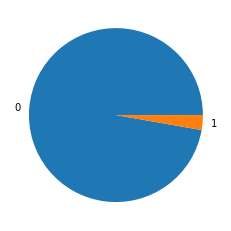

In [52]:
#Проверим распределение классов
plt.pie(target['flag'].value_counts(), labels=target['flag'].value_counts().index) #Классы распределены неравномерно, что накладывает на нас некоторые ограничения

Сгенерировать тренировочную, валидационную и тестовую 
выборки (500000 клиентов в тренировочной и по 250000 в 
валидационной и тестовой со случайным перемешиванием).

In [53]:
train = train_for_an.merge(target[['app_id', 'product', 'flag']], on=['app_id'])

In [96]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score

In [56]:
cols_for_analysis_lst.append('product')

In [ ]:
train[]

In [60]:
X_train, X_valid, y_train, y_valid = train_test_split(train[cols_for_analysis_lst], train['flag'], train_size=0.5, random_state=24, shuffle=True)

In [61]:
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, train_size=0.5, random_state=24, shuffle=True)

Реализовать интерпретируемую модель-классификатор 
вероятности дефолта.

In [62]:
# Воспользуемся моделью логистической регрессии

In [63]:
# Cтандартизация данных не требуется, т.к. все данные примерно одинаковые
# Отделим столбец app_id - т. к. его ценность для модели сомнительная, но важно не потерять его

In [65]:
cols_for_analysis_lst=[
 'days_before_median',
 'hour_diff_mean',
 'amnt_mean',
 'amnt_sum',
 'count_operation_type_1',
 'count_operation_type_2',
 'count_operation_type_3',
 'count_operation_type_4',
 'count_operation_type_5',
 'count_operation_type_6',
 'count_operation_type_7',
 'count_operation_type_8',
 'count_operation_type_9',
 'count_operation_type_10',
 'count_operation_type_11',
 'count_operation_type_13',
 'count_operation_type_14',
 'count_operation_type_15',
 'count_operation_type_16',
 'count_operation_type_17',
 'count_operation_type_19',
 'count_operation_type_20',
 'count_operation_type_21',
 'count_operation_type_22',
 'count_day_of_week_1',
 'count_day_of_week_2',
 'count_day_of_week_3',
 'count_day_of_week_4',
 'count_day_of_week_5',
 'count_day_of_week_6',
 'count_day_of_week_7',
 'count_day_of_week_1',
 'count_day_of_week_2',
 'count_day_of_week_3',
 'count_day_of_week_4',
 'count_day_of_week_5',
 'count_day_of_week_6',
 'count_day_of_week_7',
 'product']

In [67]:
#Cтандартизация данных
scaler = RobustScaler()
train = scaler.fit_transform(X_train[cols_for_analysis_lst])

In [68]:
#Используем logistic_regression

In [98]:
model = LinearRegression()

In [99]:
m1 = model.fit(train, y_train)

In [100]:
scaler = RobustScaler()
valid= scaler.fit_transform(X_valid[cols_for_analysis_lst])

In [102]:
k = m1.predict(valid)

Провести тестирование полученного классификатора разными 
метриками (не менее 3, обосновать их выбор)

In [103]:
roc_auc_score(y_valid, k) # Выбираю эту метрику, так как она позволяет учитывать несбалансированность классов, существующую в выборке

0.6856852743565417

In [104]:
#Рассмотрим одну из стандартных метрик accuracy, также учитывающую несбалансированность классов
from sklearn.metrics import balanced_accuracy_score

In [105]:
import numpy as np

In [106]:
k1 = []
for el in k:
  if el >0.5:
    k1.append(1)
  else:
    k1.append(0)

In [107]:
balanced_accuracy_score(y_valid, k1) # Виидно, что при приведении к классам качество модели очень плохое

0.49999786543715846

In [108]:
#Рассмотрим метрику f1_score
from sklearn.metrics import f1_score
f1_score(y_valid, k1) # совсем не очень

0.0

Провести интерпретацию: анализ корреляции между 
вероятностью дефолта и признаками в профиле клиента

In [80]:
#Результат так себе, попробуем интерпретировать полученный результат

In [94]:
#Получим коэффициенты модели

In [111]:
len(m1.coef_) #Всего у нас 81 признак рассмотрим 10 самых значимых

81

In [114]:
len(X_train[cols_for_analysis_lst].columns)

81

In [125]:
coef_lst = []
for el, i  in zip(X_train[cols_for_analysis_lst], m1.coef_):
  coef_lst.append((el, i, abs(i)))

In [128]:
sorted(coef_lst, key=lambda x: x[2], reverse=True)[:10] # отберем самые большие по модулю признаки с наибольшим влиянием

[('amnt_sum', -0.033804622920731844, 0.033804622920731844),
 ('count_operation_type_1', 0.01928469404611039, 0.01928469404611039),
 ('count_operation_type_2', 0.012222430092210712, 0.012222430092210712),
 ('amnt_mean', -0.01147353308749751, 0.01147353308749751),
 ('days_before_median', -0.008274653470054705, 0.008274653470054705),
 ('count_operation_type_3', 0.005779431634183228, 0.005779431634183228),
 ('product', 0.0033017757659127072, 0.0033017757659127072),
 ('count_operation_type_5', 0.003114950806417128, 0.003114950806417128),
 ('count_operation_type_4', 0.0030115949026307434, 0.0030115949026307434),
 ('count_operation_type_20', 0.0027333863433680536, 0.0027333863433680536)]

In [ ]:
# В целом влияние каждого коэффициента можно описать по формуле:
# При увеличении значения признака на 1 Вероятность дефолта изменяется на значение коэффициента

In [ ]:
#amnt_sum -Самый важный признак это сумма транзакций, чем больше сумма транзакций, тем ниже вероятность дефолта со стороны клиента Увеличение данного показателя на 1 снижает вероятность дефолта на 0.033
#count_operation_type_1 - видно, что важными признаками является число операций 1 и 2 ( эти типа операций самые популярные и чем больше таких операций, тем выше вероятность дефолта)
#count_operation_type_2 - 
#amnt_mean- чем выше среднее значение сумм транзакций клиента, тем меньше вероятность дефолта
# days_before_median - чем больше дней до кредита (чем более ранним планированием занимается клиент, тем меньше вероятность дефолта)
#count_operation_type_3 - наличие операций 3, 4, 5 в равной степени повышает вероятность дефолта
#count_operation_type_4 
#count_operation_type_5
#'product' - выгоднее выбирать продукты выше значением
#count_operation_type_20 - также и количество операций типа 20 повышает вероятность дефолта 